This notebook shows the general capability of training the ArmaNet model on dataset020. The datasets are automatically downlaoded from Zenodo and the model is trained using one seed. Within the first 400 epochs, R2 is above 75 % on the test set and in case of using one Tesla V100, the training of 400 epochs should roughly take 2 hours.

To obtain the results given in the paper, 1500 epochs must be trained and one has to take into account, that the results in the paper are averaged over three seeds, but the script in this notebook only considers one seed.

Before executing the script, a conda environment should be generated using the conda_env.yml from GitHub.

This script requires the file gnn_models.py in the same directory.

In [1]:
import wget
import os
import zipfile

from pathlib import Path

from gnn_models import GNNmodule, gnn_snbs_surv
from torch_geometric.data import DataLoader

import matplotlib.pyplot as plt

##########
# download and unzip datasets
def automatically_download_datasets(path_for_datasets):
    zenodo_url = 'https://zenodo.org/record/6572973/files/'
    dataset020_url = zenodo_url + 'dataset020.zip'
    dataset100_url = zenodo_url + 'dataset100.zip'
    datasettexas_url = zenodo_url + 'dataset_texas.zip'

    if os.path.isdir(path_for_datasets)==False:
        os.mkdir(path_for_datasets)

    dataset020_zip = path_for_datasets + '/dataset020.zip'
    dataset100_zip = path_for_datasets + '/dataset100.zip'
    if os.path.isfile(dataset020_zip) == False:
        wget.download(dataset020_url,"downloaded_datasets")
        
    if os.path.isfile(dataset100_zip) == False:
        wget.download(dataset100_url,"downloaded_datasets")


def unzip_datasets(path_for_datasets):
    dataset020_zip = path_for_datasets + '/dataset020.zip'
    dataset100_zip = path_for_datasets + '/dataset100.zip'
    with zipfile.ZipFile(dataset020_zip, 'r') as zip_ref:
        zip_ref.extractall(path_for_datasets)
    with zipfile.ZipFile(dataset100_zip, 'r') as zip_ref:
        zip_ref.extractall(path_for_datasets)



# The datasets will be downloaded and stored in path_for_datasets, change if desired.
path_for_datasets = 'downloaded_datasets'
automatically_download_datasets(path_for_datasets) ## in case of manual download, put the zip files in path_for_dataset and remove this line

unzip_datasets(path_for_datasets)
########


result_path= Path("training_run_directory")
if os.path.isdir(result_path)==False:
    os.mkdir(result_path)




# config for training
cfg = {}
# dataset
cfg["dataset::path"] = Path(path_for_datasets + '/dataset020')
cfg["task"] = "snbs"
# cfg["train_set::start_index"] = 0
# cfg["train_set::end_index"] = 799

# dataset batch sizes
cfg["train_set::batchsize"] = 228
# cfg["train_set::batchsize"] = tune.choice([150, 1000])
# cfg["train_set::batchsize"] = tune.randint(150,1000)
cfg["test_set::batchsize"] = 500
cfg["valid_set::batchsize"] = 500
cfg["train_set::shuffle"] = True
cfg["test_set::shuffle"] = False
cfg["valid_set::shuffle"] = False


# ray settings
cfg["save_after_epochs"] = 100
cfg["checkpoint_freq"] = 100
cfg["num_samples"] = 5
cfg["ray_name"] = "ArmaNet3l"

# model settings
cfg["model_name"] = "ArmaNet_ray"
cfg["final_linear_layer"] = False
cfg["num_layers"] = 3
# cfg["max_num_channels"] = 157 
cfg["num_channels1"] = 1  #tune.randint(1, cfg["max_num_channels"])
cfg["num_channels2"] = 35  #tune.randint(1, cfg["max_num_channels"])
cfg["num_channels3"] = 96 #tune.randint(1, cfg["max_num_channels"])
cfg["num_channels4"] = 1  #tune.randint(1, cfg["max_num_channels"]

cfg["batch_norm_index"] = [True, True, True]
cfg["activation"] = ["relu","relu","None"]

# ARMA
cfg["ARMA::num_internal_layers"] = [7, 9, 1]
cfg["ARMA::num_internal_stacks"] = [51, 7, 45]

cfg["ARMA::max_num_internal_layers"] = 4
cfg["ARMA::num_internal_layers1"] = 7 #tune.randint(1,cfg["ARMA::max_num_internal_layers"])
cfg["ARMA::num_internal_layers2"] = 9 #tune.randint(1,cfg["ARMA::max_num_internal_layers"])
cfg["ARMA::num_internal_layers3"] = 1
## cfg["ARMA::num_internal_layers4"] = 4
## cfg["ARMA::num_internal_layers5"] = 4
## cfg["ARMA::num_internal_layers6"] = 4


#cfg["ARMA::max_num_internal_stacks"] = 3
cfg["ARMA::num_internal_stacks1"] = 51 # tune.randint(1,cfg["ARMA::max_num_internal_stacks"])
cfg["ARMA::num_internal_stacks2"] = 7 # tune.randint(1,cfg["ARMA::max_num_internal_stacks"])
cfg["ARMA::num_internal_stacks3"] = 45


# cfg["ARMA::num_internal_layers"] = [tune.randint(1,10), tune.randint(1,10)]
# cfg["ARMA::num_internal_stacks"] = [tune.randint(1,100), tune.randint(1,100)]
cfg["ARMA::dropout"] = .25
cfg["ARMA::shared_weights"] = True
## GCN
#cfg["GCN::improved"] = True
#
## TAG
#cfg["TAG::K_hops"] = [tune.randint(1,12), tune.randint(1,12), tune.randint(1,12)]

# training settings
cfg["cuda"] = True
#cfg["num_workers"] = 1
#cfg["num_threads"] = 2
# cfg["manual_seed"] = 1
# cfg["manual_seed"] = [tune.choice([1,2,3,4,5])]
cfg["manual_seed"] = 4
# cfg["epochs"] = 1500
cfg["epochs"] = 400
cfg["optim::optimizer"] = "SGD"
cfg["optim::LR"] = 3.0
# cfg["optim::LR"] = tune.loguniform(1e-4, 2e1)
# cfg["optim::LR"] = tune.choice([1e-4, 1e-2])
cfg["optim::momentum"] = .9
cfg["optim::weight_decay"] = 1e-9
cfg["optim::scheduler"] = None
# cfg["optim::scheduler"] = tune.choice(["None", "stepLR", "ReduceLROnPlateau"])
cfg["optim::ReducePlat_patience"] = 20
cfg["optim::LR_reduce_factor"] = .7
cfg["optim::stepLR_step_size"] = 30
# cfg["optim::scheduler"] = "stepLR"
cfg["criterion"] = "MSELoss"
cfg["search_alg"] = "Optuna"
# cfg["search_alg"] = None

# evaluation
cfg["eval::threshold"] = .1

# initialize model
gnnmodule = GNNmodule(cfg)


# init datasets and dataloader
train_set = gnn_snbs_surv(cfg["dataset::path"] / 'train',cfg["task"])
valid_set = gnn_snbs_surv(cfg["dataset::path"] / 'valid', cfg["task"])
test_set = gnn_snbs_surv(cfg["dataset::path"] / 'test', cfg["task"])
train_loader = DataLoader(
    train_set, batch_size=cfg["train_set::batchsize"], shuffle=cfg["train_set::shuffle"])
valid_loader = DataLoader(
    train_set, batch_size=cfg["valid_set::batchsize"], shuffle=cfg["valid_set::shuffle"])
test_loader = DataLoader(
    test_set, batch_size=cfg["test_set::batchsize"], shuffle=cfg["test_set::shuffle"])

train_loss_all_epochs = []
train_accu_all_epochs = []
train_R2_all_epochs = []

test_loss_all_epochs = []
test_accu_all_epochs = []
test_R2_all_epochs = []

epochs = cfg["epochs"]
for epoch in range(1,epochs):
    print(f"Epoch {epoch}/{epochs}.. ")
    train_loss, train_accu, train_R2 = gnnmodule.train_epoch(train_loader, cfg["eval::threshold"])
    train_loss_all_epochs.append(train_loss)
    train_accu_all_epochs.append(train_accu)
    train_R2_all_epochs.append(train_R2)
    test_loss, test_accu, test_R2 = gnnmodule.eval_model(test_loader, cfg["eval::threshold"])
    test_loss_all_epochs.append(test_loss)
    test_accu_all_epochs.append(test_accu)
    test_R2_all_epochs.append(test_R2)
    print('train R2: ''{:3.2f}'.format(100 * train_R2) + '%')
    print('train accu: ''{:3.2f}'.format(train_accu) + '%')
    print('test R2: ''{:3.2f}'.format(100 * test_R2) + '%')
    print('test accu: ''{:3.2f}'.format(test_accu) + '%')
print("finished")

cuda availabe:: send model to GPU
Epoch 1/400.. 
train R2: -260.57%
test R2: -238.86%
Epoch 2/400.. 
train R2: -225.58%
test R2: -238.88%
Epoch 3/400.. 
train R2: -222.62%
test R2: -238.82%
Epoch 4/400.. 
train R2: -214.19%
test R2: -238.74%
Epoch 5/400.. 
train R2: -192.35%
test R2: -238.24%
Epoch 6/400.. 
train R2: -144.94%
test R2: -229.45%
Epoch 7/400.. 
train R2: -42.40%
test R2: -12.81%
Epoch 8/400.. 
train R2: 14.41%
test R2: -19.36%
Epoch 9/400.. 
train R2: 29.26%
test R2: -8.86%
Epoch 10/400.. 
train R2: 35.17%
test R2: -4.88%
Epoch 11/400.. 
train R2: 38.29%
test R2: -1.46%
Epoch 12/400.. 
train R2: 39.84%
test R2: 7.55%
Epoch 13/400.. 
train R2: 41.40%
test R2: 8.47%
Epoch 14/400.. 
train R2: 42.04%
test R2: 6.82%
Epoch 15/400.. 
train R2: 43.28%
test R2: 12.66%
Epoch 16/400.. 
train R2: 44.31%
test R2: 13.97%
Epoch 17/400.. 
train R2: 45.09%
test R2: 10.67%
Epoch 18/400.. 
train R2: 45.38%
test R2: 19.24%
Epoch 19/400.. 
train R2: 46.26%
test R2: 18.14%
Epoch 20/400.. 
trai

train R2: 73.67%
test R2: 66.45%
Epoch 167/400.. 
train R2: 73.97%
test R2: 56.47%
Epoch 168/400.. 
train R2: 73.77%
test R2: 47.11%
Epoch 169/400.. 
train R2: 74.01%
test R2: 58.35%
Epoch 170/400.. 
train R2: 73.81%
test R2: 54.73%
Epoch 171/400.. 
train R2: 74.25%
test R2: 62.10%
Epoch 172/400.. 
train R2: 74.02%
test R2: 67.47%
Epoch 173/400.. 
train R2: 74.53%
test R2: 38.53%
Epoch 174/400.. 
train R2: 74.06%
test R2: 61.16%
Epoch 175/400.. 
train R2: 74.49%
test R2: 67.82%
Epoch 176/400.. 
train R2: 74.38%
test R2: 55.43%
Epoch 177/400.. 
train R2: 74.53%
test R2: 63.42%
Epoch 178/400.. 
train R2: 74.45%
test R2: 66.24%
Epoch 179/400.. 
train R2: 74.31%
test R2: 56.66%
Epoch 180/400.. 
train R2: 74.59%
test R2: 64.09%
Epoch 181/400.. 
train R2: 74.86%
test R2: 68.74%
Epoch 182/400.. 
train R2: 74.71%
test R2: 47.53%
Epoch 183/400.. 
train R2: 74.82%
test R2: 69.35%
Epoch 184/400.. 
train R2: 74.77%
test R2: 44.92%
Epoch 185/400.. 
train R2: 74.85%
test R2: 60.40%
Epoch 186/400.. 


train R2: 78.56%
test R2: 74.27%
Epoch 331/400.. 
train R2: 78.14%
test R2: 68.46%
Epoch 332/400.. 
train R2: 78.07%
test R2: 69.47%
Epoch 333/400.. 
train R2: 78.29%
test R2: 62.70%
Epoch 334/400.. 
train R2: 78.31%
test R2: 75.40%
Epoch 335/400.. 
train R2: 78.93%
test R2: 72.48%
Epoch 336/400.. 
train R2: 78.72%
test R2: 73.51%
Epoch 337/400.. 
train R2: 78.67%
test R2: 70.93%
Epoch 338/400.. 
train R2: 78.69%
test R2: 74.18%
Epoch 339/400.. 
train R2: 78.99%
test R2: 70.20%
Epoch 340/400.. 
train R2: 78.40%
test R2: 67.15%
Epoch 341/400.. 
train R2: 78.80%
test R2: 76.32%
Epoch 342/400.. 
train R2: 79.04%
test R2: 73.61%
Epoch 343/400.. 
train R2: 78.83%
test R2: 73.82%
Epoch 344/400.. 
train R2: 79.06%
test R2: 73.00%
Epoch 345/400.. 
train R2: 78.94%
test R2: 74.42%
Epoch 346/400.. 
train R2: 78.73%
test R2: 72.54%
Epoch 347/400.. 
train R2: 78.65%
test R2: 72.62%
Epoch 348/400.. 
train R2: 79.03%
test R2: 70.37%
Epoch 349/400.. 
train R2: 78.97%
test R2: 73.67%
Epoch 350/400.. 


At the beginning R2, is very low, hence the limits of the axis can be set if desired. The default settings are to start plotting after the first 8 epochs.

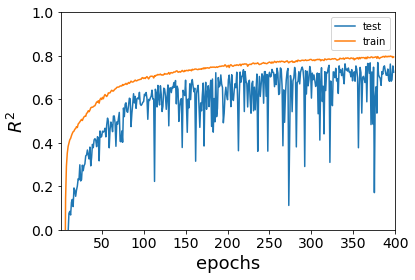

In [10]:
fig, ax = plt.subplots(1,1)
ax.plot(test_R2_all_epochs, label="test")
ax.plot(train_R2_all_epochs, label="train")
ax.set_ylabel('$R^2$',fontsize=18)
ax.set_xlabel('epochs',fontsize=18)
ax.set_xlim([1,epochs])
# ax.set_xlim=[5,8]
# ax.set_ylim=[0,1]
ax.set_ylim([0,1])
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.legend()
plt.show()